In this notebook we test the 2 differents custom logistic regression we've built in other notebooks for learning from credal labels and compare their performances with sklearn logistic regression and a logistic regression built with pytorch

# Import libraries

In [1]:
import sys
sys.path.append('../python_code/')
def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn

import torch
import torch.nn as nn
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('white')
sns.set_context("paper", font_scale = 2)

from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

from custom_logistic_regression import CustomLogisticRegression
from utils import get_accuracy

import pingouin as pg

## Creation of a function to transform hard labels into credal labels

In [2]:
def transform_to_interval_int(variable: int) -> np.ndarray:
    """
    Transform a hard label into an interval of probabilities.
    If the label is 0, the created interval will be in the range of
    [0, 0.49], else it will be in the range of [0.5, 1]
    
    Args:
        variable (int): variable to transform
    
    Returns:
        (np.ndarray): created interval 
    """
    if variable == 0:
        interval = np.sort(
            np.round(
                np.random.uniform(
                    low=0.0,
                    high=0.49,
                    size=(2,)
                ),
                decimals=2
            )
        )
    else:
        interval = np.sort(
            np.round(
                np.random.uniform(
                    low=0.5,
                    high=1.0,
                    size=(2,)
                ),
                decimals=2
            )
        )
    return interval

# Load data

To test our models and compare their performances, we use the UCI ML Breast Cancer Wisconsin data set

In [3]:
data = load_breast_cancer(as_frame=True).frame
data.head()

,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension,target
0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,...,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890,0
1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,...,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902,0
2,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,...,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758,0
3,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,0.09744,...,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300,0
4,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,0.05883,...,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678,0


In [4]:
data["target_intervals"] = data["target"].apply(transform_to_interval_int)
data.head()

,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension,target,target_intervals
0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,...,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890,0,"[0.25, 0.33]"
1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,...,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902,0,"[0.31, 0.45]"
2,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,...,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758,0,"[0.05, 0.24]"
3,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,0.09744,...,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300,0,"[0.46, 0.47]"
4,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,0.05883,...,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678,0,"[0.4, 0.47]"


# Scaling data

We scale the data to have less sparse weights in our model

In [49]:
scale = StandardScaler()
x_train = pd.DataFrame(
    scale.fit_transform(data.drop(["target", "target_intervals"], axis=1)),
    columns = data.drop(["target", "target_intervals"], axis=1).columns
)
x_train.head()

,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst radius,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension
0,1.097064,-2.073335,1.269934,0.984375,1.568466,3.283515,2.652874,2.532475,2.217515,2.255747,...,1.886690,-1.359293,2.303601,2.001237,1.307686,2.616665,2.109526,2.296076,2.750622,1.937015
1,1.829821,-0.353632,1.685955,1.908708,-0.826962,-0.487072,-0.023846,0.548144,0.001392,-0.868652,...,1.805927,-0.369203,1.535126,1.890489,-0.375612,-0.430444,-0.146749,1.087084,-0.243890,0.281190
2,1.579888,0.456187,1.566503,1.558884,0.942210,1.052926,1.363478,2.037231,0.939685,-0.398008,...,1.511870,-0.023974,1.347475,1.456285,0.527407,1.082932,0.854974,1.955000,1.152255,0.201391
3,-0.768909,0.253732,-0.592687,-0.764464,3.283553,3.402909,1.915897,1.451707,2.867383,4.910919,...,-0.281464,0.133984,-0.249939,-0.550021,3.394275,3.893397,1.989588,2.175786,6.046041,4.935010
4,1.750297,-1.151816,1.776573,1.826229,0.280372,0.539340,1.371011,1.428493,-0.009560,-0.562450,...,1.298575,-1.466770,1.338539,1.220724,0.220556,-0.313395,0.613179,0.729259,-0.868353,-0.397100


# With sklearn logistic regression with scaling

In [9]:
lr = LogisticRegression(max_iter=200)
lr.fit(x_train, data["target"])
predictions = lr.predict(x_train)
accuracy_score(data["target"], predictions)

0.9876977152899824

We obtained approximately 0.99 of train accuracy with the built-in sklearn logistic regression

# With custom logistic regression with scaling

In [10]:
lr3 = CustomLogisticRegression(number_iteration=200, learning_rate=0.0001)
lr3.fit(x_train=x_train, y_train=data["target_intervals"])
lr3.accuracies[199]

0.9806678383128296

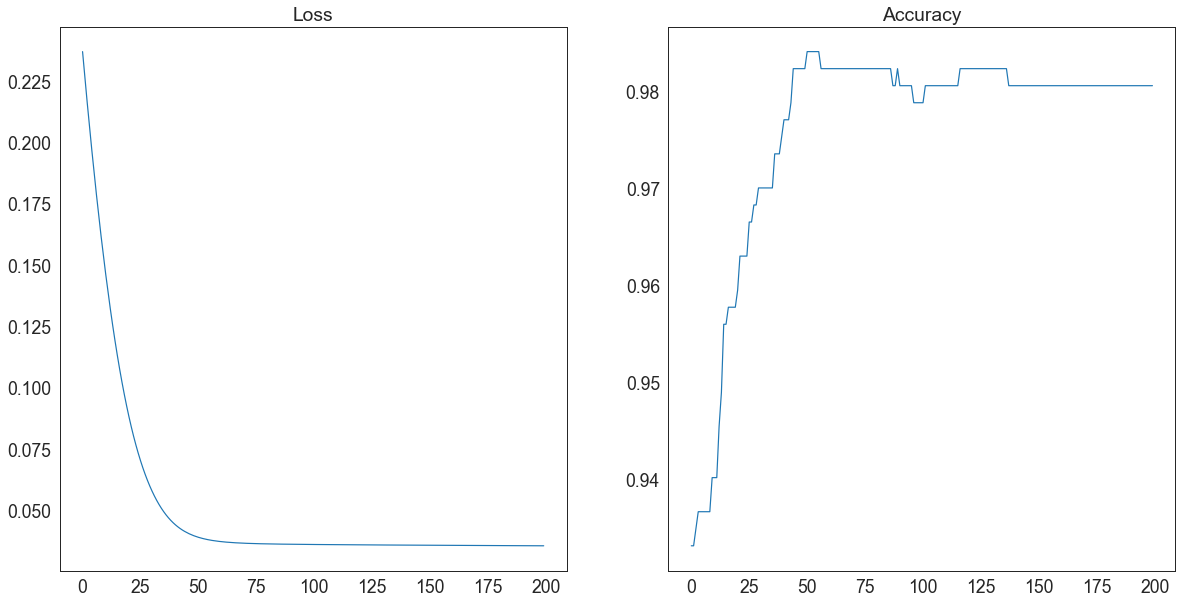

In [11]:
_, axes = plt.subplots(1, 2, figsize=(20, 10))
sns.lineplot(x=lr3.losses.keys(), y=lr3.losses.values(), ax=axes[0]).set(title="Loss")
sns.lineplot(x=lr3.accuracies.keys(), y=lr3.accuracies.values(), ax=axes[1]).set(title="Accuracy")
plt.show()

We can see that with our custom logistic regression, we obtained a 0.98 train accuracy on the same dataset with credal labels. The performances seem to be quite similar

# With classical logistic regression using PyTorch with scaling

Now we use the pytorch library to build a logistic regression and see if we can build a logistic regression (and further deep neural networks) with the ability to learn from credal labels

In [50]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

Using cpu device


In [13]:
class LogisticRegressionPytorch(torch.nn.Module):
    def __init__(self, input_dim, output_dim, learning_rate):
        super().__init__()
        self.logistic = nn.Linear(input_dim, output_dim)
        self.criterion = nn.BCELoss(reduction="mean")
        self.shape_parameters_estimated = torch.zeros(
            input_dim, output_dim, dtype=torch.float32, requires_grad=True
        )
        self.optimizer = torch.optim.SGD(self.logistic.parameters(), lr=learning_rate)
        self.losses = []
        self.accuracies = []
    
    def forward(self, x_train):
        outputs = self.logistic(x_train)
        outputs = torch.sigmoid(outputs)
        return outputs
    
    def fit(self, x_train, y_train, epochs=10):
        for _ in range(epochs):
            outputs = self(x_train)
            loss = self.criterion(outputs, y_train.reshape(-1, 1))
            self.losses.append(loss.detach().numpy())
            self.accuracies.append(accuracy_score(
                y_true=y_train, y_pred=outputs.reshape(-1).detach().numpy().round())
            )
            loss.backward()
            self.optimizer.step()

In [14]:
epochs = 200
input_dim = 30 
output_dim = 1 # Single binary output 
learning_rate = 0.001

X_train = torch.from_numpy(x_train.values.astype(np.float32))
Y_train = torch.from_numpy(data["target"].values.astype(np.float32))

model = LogisticRegressionPytorch(input_dim,output_dim, learning_rate=learning_rate)
print(model)
model.fit(x_train=X_train, y_train=Y_train, epochs=epochs)

LogisticRegressionPytorch(
  (logistic): Linear(in_features=30, out_features=1, bias=True)
  (criterion): BCELoss()
)


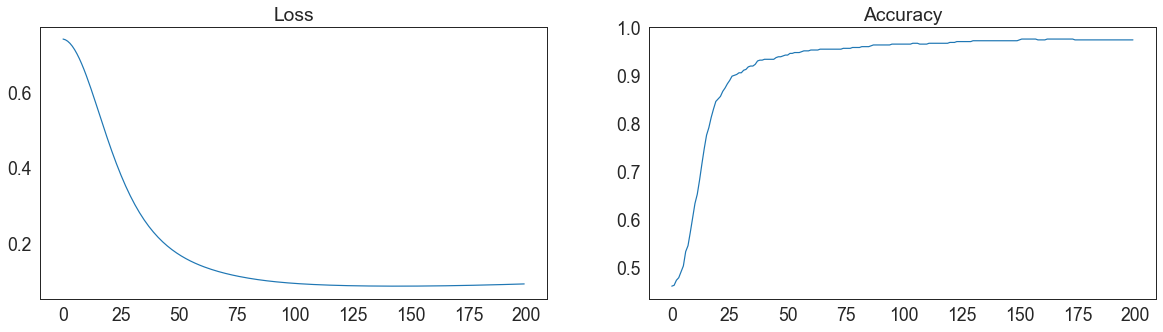

In [15]:
_, axes = plt.subplots(1, 2, figsize=(20, 5))
sns.lineplot(x=[i for i in range(epochs)], y=[float(loss) for loss in model.losses], ax=axes[0]).set(title="Loss")
sns.lineplot(x=[i for i in range(epochs)], y=model.accuracies, ax=axes[1]).set(title="Accuracy")
plt.show()

In [16]:
model.accuracies[-1]

0.9736379613356766

# With custom logistic regression using PyTorch with scaling

In [17]:
def KLD_loss_intervals(y_true, y_pred):
    y_true = torch.from_numpy(np.stack(y_true.values).astype(np.float32))
    y_true_inf = y_true[:, 0].reshape(-1, 1)
    y_true_sup = y_true[:, 1].reshape(-1, 1)
    used_probas = torch.zeros(y_true.shape[0], 1)
    used_probas[y_pred <= y_true_inf] = y_true_inf[y_pred <= y_true_inf]
    used_probas[y_pred >= y_true_sup] = y_true_inf[y_pred >= y_true_sup]
    used_probas[(y_pred >= y_true_inf) & (y_pred <= y_true_sup)
                ] = y_pred[(y_pred >= y_true_inf) & (y_pred <= y_true_sup)]
    kld = nn.KLDivLoss(reduction="batchmean", log_target=False)
    loss = kld(y_pred, used_probas) + kld(1-y_pred, 1-used_probas)
    return loss

In [18]:
class CustomLogisticRegressionPytorch(torch.nn.Module):
    def __init__(self, input_dim, output_dim, learning_rate):
        super().__init__()
        self.logistic = nn.Linear(input_dim, output_dim)
        self.shape_parameters_estimated = torch.zeros(
            input_dim, output_dim, dtype=torch.float32, requires_grad=True
        )
        self.optimizer = torch.optim.SGD(self.logistic.parameters(), lr=learning_rate)
        self.losses = []
        self.accuracies = []
    
    def forward(self, x_train):
        outputs = self.logistic(x_train)
        outputs = torch.sigmoid(outputs)
        return outputs
    
    def fit(self, x_train, y_train, hypotetic_labels, epochs=10):
        for _ in range(epochs):
            outputs = self(x_train)
            loss = KLD_loss_intervals(y_train, outputs)
            self.losses.append(loss.detach().numpy())
            self.accuracies.append(accuracy_score(
                y_true=hypotetic_labels, y_pred=outputs.reshape(-1).detach().numpy().round())
            )
            loss.backward()
            self.optimizer.step()

In [19]:
epochs = 200
input_dim = 30 
output_dim = 1 # Single binary output 
learning_rate = 0.1

X_train = torch.from_numpy(x_train.values.astype(np.float32))
Y_train = data["target_intervals"]

model = CustomLogisticRegressionPytorch(input_dim, output_dim, learning_rate=learning_rate)
print(model)
model.fit(x_train=X_train, y_train=Y_train, hypotetic_labels=data["target"], epochs=epochs)

CustomLogisticRegressionPytorch(
  (logistic): Linear(in_features=30, out_features=1, bias=True)
)


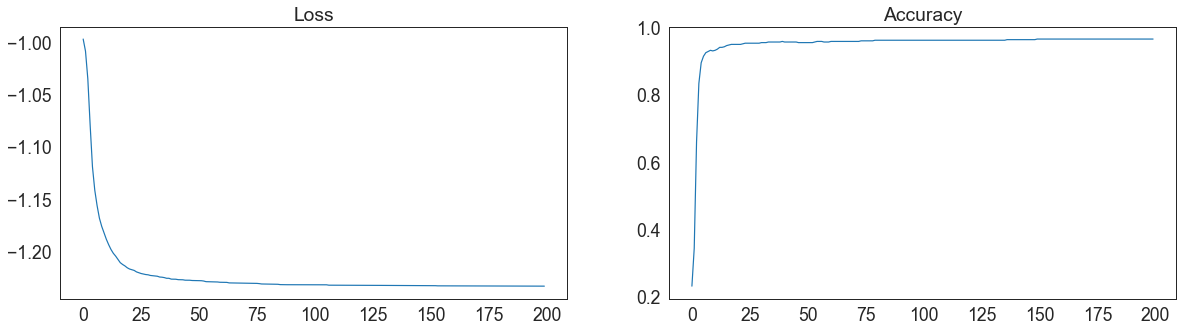

In [20]:
_, axes = plt.subplots(1, 2, figsize=(20, 5))
sns.lineplot(x=[i for i in range(epochs)], y=[float(loss) for loss in model.losses], ax=axes[0]).set(title="Loss")
sns.lineplot(x=[i for i in range(epochs)], y=model.accuracies, ax=axes[1]).set(title="Accuracy")
plt.show()

In [21]:
model.accuracies[-1]

0.9648506151142355

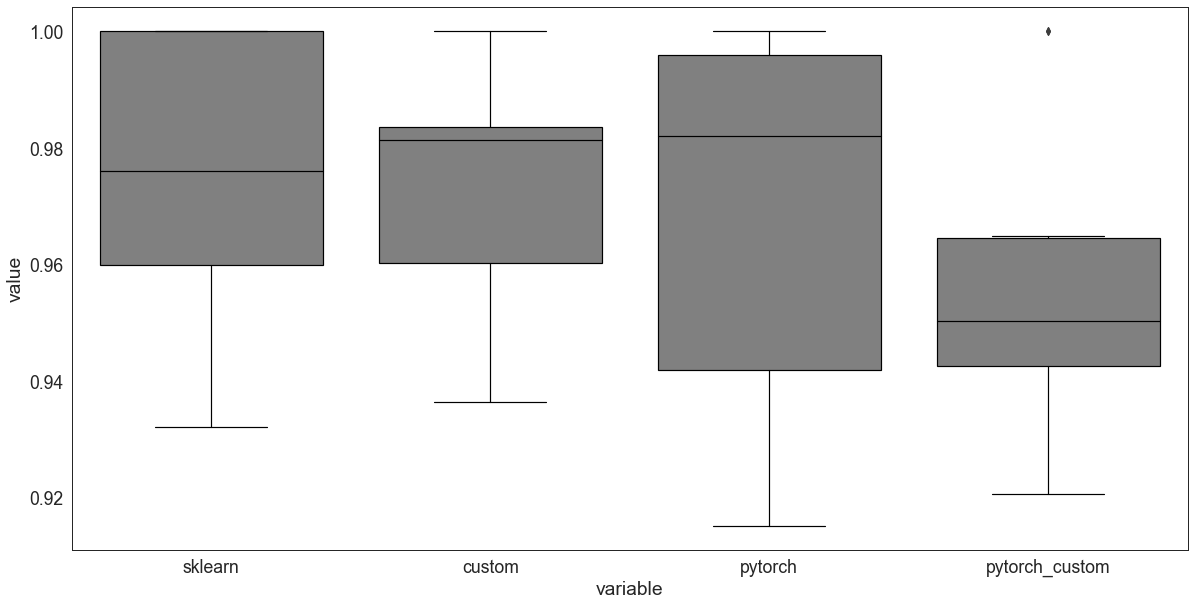

In [42]:
k_fold = 10
accuracies = {
    "sklearn": {},
    "custom": {},
    "pytorch": {},
    "pytorch_custom": {},
}
fold = np.random.randint(0, 10, len(data))
x_train["fold"] = fold
y_train = data[["target", "target_intervals"]]
y_train["fold"] = fold
for i in range(k_fold):
    x_a = x_train[x_train["fold"] != i].drop("fold", axis=1)
    y_a = y_train[y_train["fold"] != i].drop("fold", axis=1)
    x_b = x_train[x_train["fold"] == i].drop("fold", axis=1)
    y_b = y_train[y_train["fold"] == i].drop("fold", axis=1)
    X_train_py = torch.from_numpy(x_a.values.astype(np.float32))
    Y_train_py = torch.from_numpy(y_a["target"].values.astype(np.float32))
    X_train_pyc = torch.from_numpy(x_a.values.astype(np.float32))
    Y_train_pyc = y_a["target_intervals"]

    lr_sklearn = LogisticRegression(max_iter=200)
    lr_custom = CustomLogisticRegression(
        number_iteration=200, learning_rate=0.0001)
    lr_pytorch = LogisticRegressionPytorch(
        input_dim=30, output_dim=1, learning_rate=0.1)
    lr_pytorch_custom = CustomLogisticRegressionPytorch(
        input_dim, output_dim, learning_rate=0.01)

    lr_sklearn.fit(x_a, y_a["target"])
    lr_custom.fit(x_a, y_a["target_intervals"])
    lr_pytorch.fit(X_train_py, Y_train_py, epochs=200)
    lr_pytorch_custom.fit(X_train_pyc, Y_train_pyc,
                          hypotetic_labels=y_a["target"], epochs=epochs)

    pred_lr_sklearn = lr_sklearn.predict(x_b)
    pred_lr_custom = np.round(lr_custom.predict(x_b)).reshape(-1)
    pred_lr_pytorch = lr_pytorch.forward(torch.from_numpy(
        x_b.values.astype(np.float32))).reshape(-1).detach().numpy().round()
    pred_lr_pytorch_custom = lr_pytorch_custom.forward(torch.from_numpy(
        x_b.values.astype(np.float32))).reshape(-1).detach().numpy().round()
    
    accuracies["sklearn"][i] = accuracy_score(y_b["target"], pred_lr_sklearn)
    accuracies["custom"][i] = accuracy_score(y_b["target"], pred_lr_custom)
    accuracies["pytorch"][i] = accuracy_score(y_b["target"], pred_lr_pytorch)
    accuracies["pytorch_custom"][i] = accuracy_score(y_b["target"], pred_lr_pytorch_custom)
acc = pd.DataFrame(accuracies)
plt.figure(figsize=(20, 10))
ax = sns.boxplot(x=pd.melt(acc)["variable"], y=pd.melt(acc)["value"])
for i,box in enumerate(ax.artists):
    box.set_edgecolor('black')
    box.set_facecolor('grey')

    # iterate over whiskers and median lines
    for j in range(6*i,6*(i+1)):
         ax.lines[j].set_color('black')
plt.show()

In [43]:
aov = pg.anova(data=pd.melt(acc), dv='value', between='variable', detailed=True)
print(aov)

     Source        SS  DF        MS         F     p-unc       np2
0  variable  0.002064   3  0.000688  0.948914  0.427273  0.073281
1    Within  0.026103  36  0.000725       NaN       NaN       NaN
